In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rice-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2049052%2F3399185%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T193238Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D929c95830bf3e9f29371ab350c47211151500deff6cb0f037c0fc4d9508fa8f30bae40434181fc28092950f9315998a935fd44fa376226c54546ab05ce80d72ae4590c92f12b248f2ca031b6d21cf8cbdf3995c82044ec33b885bd94f9874050dffe16c4166c4d533daa520cf64cb013409334348e092ea6351b675ef5c90a63ab9e4725837330080469965b9b90aea7e22186f61234436ce087ab8bbd918c7a0885801fabf2ab032fa656f9afd34f90a23dd7520684952a970c6fc6f89076f3e8206c17ec9c7440ac22bb4179597df7672df2af135487e469bb12a0f63b400a7aa3a6eb143b690e9aad86503099eb56c655cc18faa145174e6adf72f009ad74'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 230059472 bytes downloaded
Downloaded and uncompressed: rice-image-dataset
Data source import complete.


In [ ]:
# !pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
import itertools

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img

import os
import pathlib

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [3]:
path = pathlib.Path("/kaggle/input/rice-image-dataset/Rice_Image_Dataset")

In [4]:
arborio = list(path.glob('Arborio/*'))[:1000]
basmati = list(path.glob('Basmati/*'))[:1000]
ipsala = list(path.glob('Ipsala/*'))[:1000]
jasmine = list(path.glob('Jasmine/*'))[:1000]
karacadag = list(path.glob('Karacadag/*'))[:1000]

In [5]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}

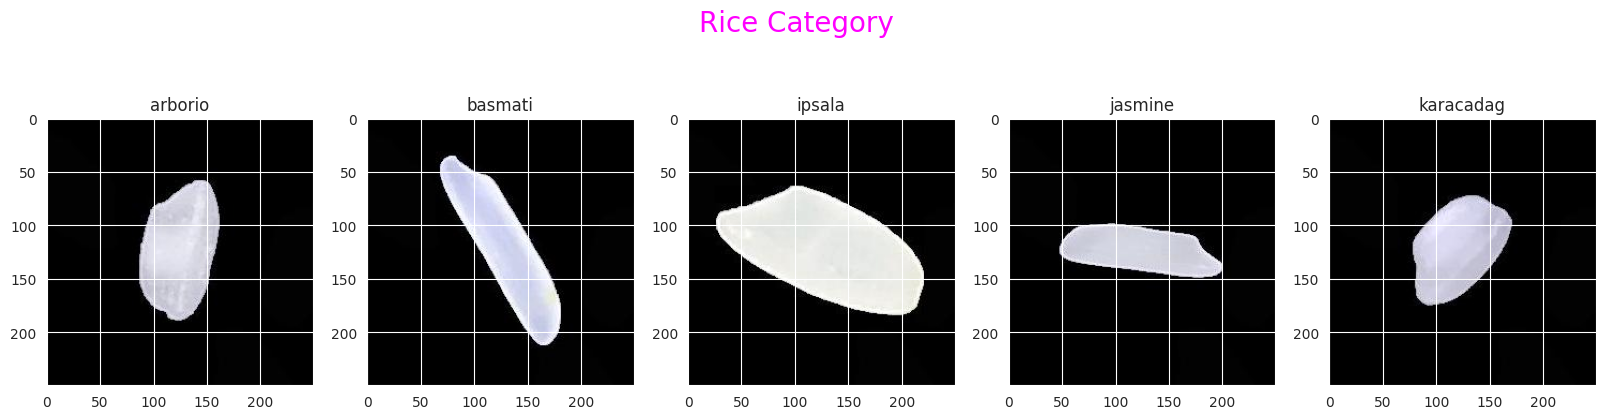

In [6]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)


In [7]:
train_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_data=train_gen.flow_from_directory("/kaggle/input/rice-image-dataset/Rice_Image_Dataset",target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True,subset='training')
test_data=train_gen.flow_from_directory("/kaggle/input/rice-image-dataset/Rice_Image_Dataset",target_size=(224,224),batch_size=1,shuffle=False,subset='validation')

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [8]:
cnn=keras.models.Sequential()
cnn.add(keras.layers.Conv2D(filters=32,kernel_size=3,
                            padding='valid',activation='relu',input_shape=(224,224,3)))
cnn.add(keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(40,activation='relu'))
cnn.add(keras.layers.Dropout(rate= 0.1, seed= 100))
cnn.add(keras.layers.Dense(units=5,activation='sigmoid'))

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 40)                15770920  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 205       
                                                        

In [10]:
cnn.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
cnn.fit(train_data,epochs=2,validation_data=test_data,shuffle=True)

Epoch 1/2
1875/1875 [==============================] - 398s 207ms/step - loss: 0.1761 - accuracy: 0.9388 - val_loss: 0.1205 - val_accuracy: 0.9510
Epoch 2/2
1875/1875 [==============================] - 247s 132ms/step - loss: 0.0847 - accuracy: 0.9722 - val_loss: 0.0720 - val_accuracy: 0.9749


In [ ]:
def plot(c):
    plt.plot(c.history.history['accuracy'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_accuracy'],marker='*',color='green',markersize=10)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(c.history.history['loss'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_loss'],marker='*',color='green',markersize=10)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()


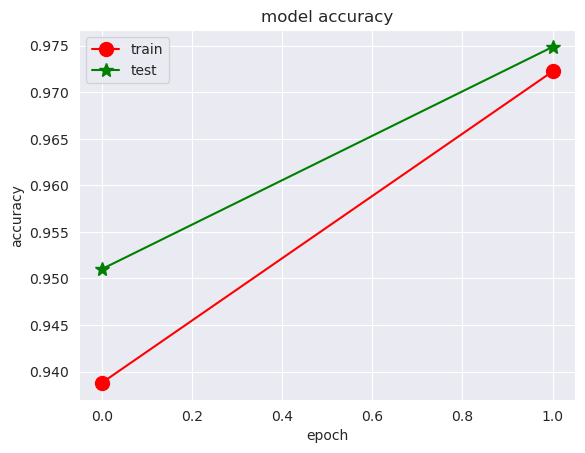

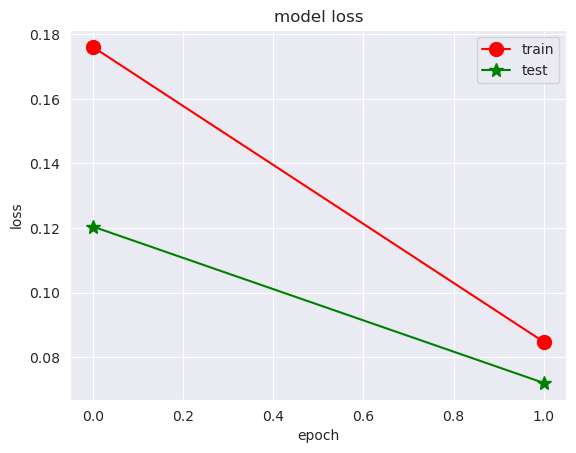

In [ ]:
plot(cnn)

In [ ]:
cnn2=keras.models.Sequential()
cnn2.add(keras.layers.Conv2D(filters=32,kernel_size=3,
                            padding='valid',activation='relu',input_shape=(224,224,3)))
cnn2.add(keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn2.add(keras.layers.Flatten())
cnn2.add(keras.layers.Dense(45,activation='relu'))
cnn2.add(keras.layers.Dense(15,activation='relu'))
cnn2.add(keras.layers.Dropout(rate= 0.1, seed= 100))
cnn2.add(keras.layers.Dense(units=5,activation='sigmoid'))

In [ ]:
cnn2.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
cnn2.fit(train_data,epochs=40,validation_data=test_data,shuffle=True,
         callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10))

Epoch 1/40
1875/1875 [==============================] - 222s 118ms/step - loss: 0.1956 - accuracy: 0.9274 - val_loss: 0.1045 - val_accuracy: 0.9670
Epoch 2/40
1875/1875 [==============================] - 227s 121ms/step - loss: 0.0665 - accuracy: 0.9790 - val_loss: 0.0401 - val_accuracy: 0.9877
Epoch 3/40
1875/1875 [==============================] - 242s 129ms/step - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0742 - val_accuracy: 0.9791
Epoch 4/40
1875/1875 [==============================] - 255s 136ms/step - loss: 0.0320 - accuracy: 0.9901 - val_loss: 0.0325 - val_accuracy: 0.9913
Epoch 5/40
1875/1875 [==============================] - 247s 132ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.0492 - val_accuracy: 0.9873
Epoch 6/40
1875/1875 [==============================] - 233s 124ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0439 - val_accuracy: 0.9877
Epoch 7/40
1875/1875 [==============================] - 228s 122ms/step - loss: 0.0205 - accuracy: 0.9945 - val_

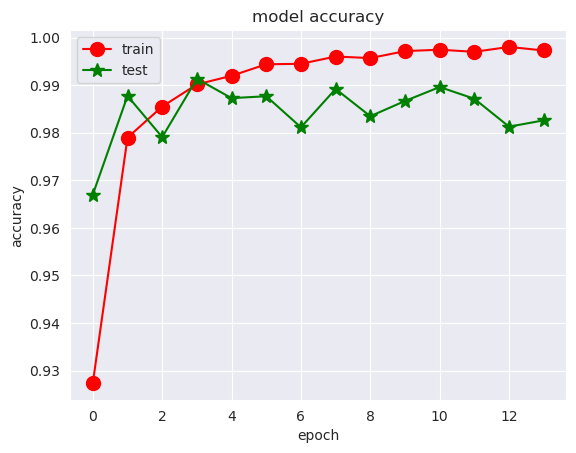

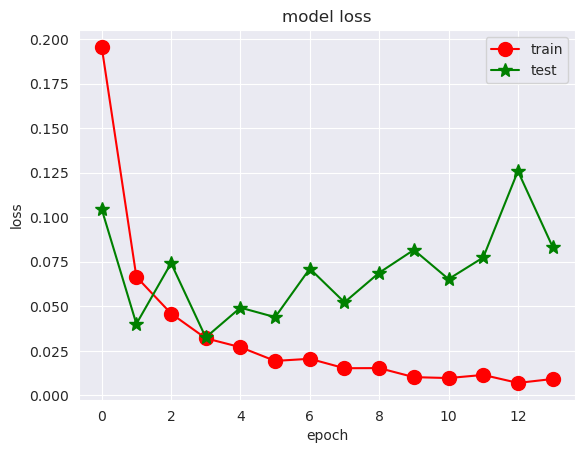

In [ ]:
plot(cnn2)

In [ ]:
y_pred = cnn2.predict(test_data)
main_y_pred = np.argmax(y_pred, axis=1)


15000/15000 [==============================] - 55s 4ms/step


In [ ]:
test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)

predictions = cnn2.predict_generator(test_data, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Arborio       0.94      0.98      0.96      3000
     Basmati       0.96      0.99      0.97      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.99      0.95      0.97      3000
   Karacadag       0.98      0.95      0.96      3000

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



array([[2929,    0,    1,    9,   61],
       [   0, 2971,    0,   29,    0],
       [   2,    0, 2997,    1,    0],
       [   9,  130,    0, 2861,    0],
       [ 161,    0,    0,    1, 2838]])

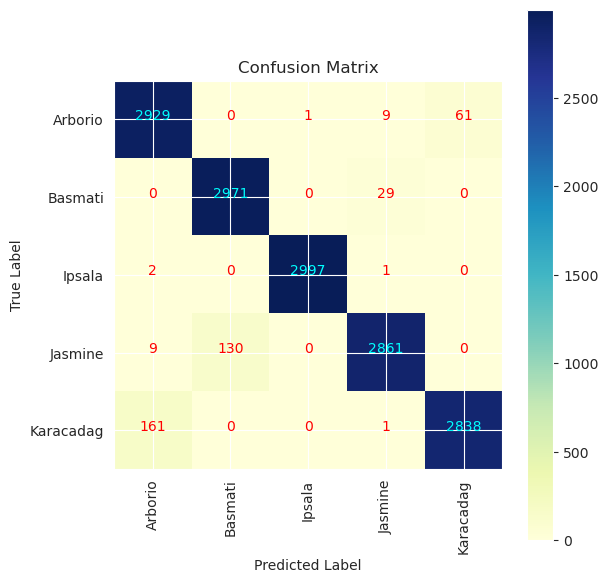

In [ ]:
cm = confusion_matrix(test_data.classes, predicted_classes)
d1=test_data.class_indices
classes = list(d1.keys())
cmap= plt.cm.YlGnBu
plt.figure(figsize= (6, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
plt.title('Confusion Matrix')
plt.colorbar(shrink=True)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 90)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'aqua' if cm[i, j] > thresh else 'red')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
cm



In [ ]:

train_score = cnn2.evaluate(train_data, verbose= 1)
test_score = cnn2.evaluate(test_data, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('*****************************')
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15000/15000 [==============================] - 72s 5ms/step - loss: 0.0834 - accuracy: 0.9826
Train Loss:  0.00332073075696826
Train Accuracy:  0.9989500045776367
*****************************
Test Loss:  0.08335919678211212
Test Accuracy:  0.9825999736785889
